## Generowanie zbioru XOR

Do stworzeniu ramki danych XOR wylosowałem liczby ze standardowego rozkładu normalnego, a następnie je zaklasyfikowałem jako 0 lub 1 w zależności na której półosi leżą.

Model posiada 2 ukryte warstwy, każda po 16 neuronów

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import plotly
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn import datasets

In [88]:
df = pd.DataFrame(np.random.randn(1000,2))
df

,0,1
0,-0.151330,1.981040
1,-1.590827,-0.026435
2,0.505632,-0.419207
3,1.608536,0.446454
4,-0.295714,1.558298
...,...,...
995,1.026931,-0.572241
996,-0.668350,-0.923613
997,-0.368273,-1.614195
998,-1.233982,1.647619


In [89]:
a = ((df[0]>0) & (df[1]>0)) | ((df[0]<0) & (df[1]<0))
a
df['value']= a.astype('int')
df

,0,1,value
0,-0.151330,1.981040,0
1,-1.590827,-0.026435,1
2,0.505632,-0.419207,0
3,1.608536,0.446454,1
4,-0.295714,1.558298,0
...,...,...,...
995,1.026931,-0.572241,0
996,-0.668350,-0.923613,1
997,-0.368273,-1.614195,1
998,-1.233982,1.647619,0


### Model

In [90]:
df1, df2 = train_test_split(
    df[df.columns.values[:]],
    test_size=0.3, random_state=42)

In [91]:
df1

,0,1,value
541,0.797287,-0.490817,0
440,0.092677,-1.509317,0
482,1.143896,0.771147,1
422,-0.692392,0.835620,0
778,-1.298666,0.542012,0
...,...,...,...
106,0.960644,0.588398,1
270,-0.430764,1.334354,0
860,1.062773,-1.092774,0
435,-0.179891,-0.651521,1


In [92]:
dataloader_train = torch.utils.data.DataLoader(np.array(df1), batch_size=1)
dataiter = iter(dataloader_train)
data = dataiter.next()

X, y = data[:,0:2],data[:,2]
X,y

(tensor([[ 0.7973, -0.4908]], dtype=torch.float64),
 tensor([0.], dtype=torch.float64))

In [101]:
net = torch.nn.Sequential(
    #torch.nn.Flatten(),
    torch.nn.Linear(2, 16), 
    torch.nn.ReLU(),
    torch.nn.Linear(16, 16), 
    torch.nn.ReLU(),
    torch.nn.Linear(16, 2)
)

def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.normal_(m.weight, std=0.01) 

net.apply(init_weights)

Sequential(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=2, bias=True)
)

In [102]:
learning_rate = 0.05
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate) # Stochastic Gradient Descent

In [103]:
num_iter = 20
batch_size = 256
dataloader_train = torch.utils.data.DataLoader(np.array(df1), batch_size=1)
dataloader_test = torch.utils.data.DataLoader(np.array(df2), batch_size=1)

losses = []
errors_train = []
errors_test = []

for epoch in range(num_iter):
    losses_iter = []
    errors_train_iter = []
    errors_test_iter = []
    
    for data in dataloader_test:
        X, y = data[:,0:2],data[:,2].long()
        y_hat = net(X.float())
        errors_test_iter += [(y != y_hat.argmax(1)).float().mean().item()]

    for data in dataloader_train:
        X, y = data[:,0:2],data[:,2].long()
        y_hat = net(X.float())
        errors_train_iter += [(y != y_hat.argmax(1)).float().mean().item()]
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.mean().backward()
        losses_iter += [l.mean().item()]
        optimizer.step()
    
    errors_train += [np.mean(errors_train_iter)]
    errors_test += [np.mean(errors_test_iter)]
    losses += [np.mean(losses_iter)]

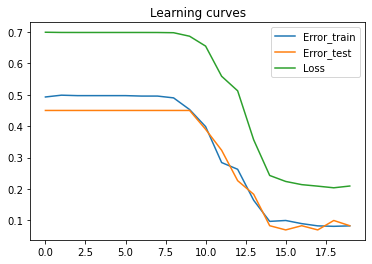

In [104]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(range(num_iter), errors_train)
plt.plot(range(num_iter), errors_test)
plt.plot(range(num_iter), losses)
plt.title("Learning curves")
plt.legend(['Error_train', 'Error_test', 'Loss'])
plt.show()

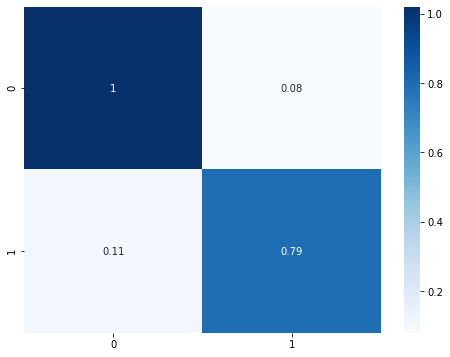

In [105]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for data in dataloader_test:
        
        inputs, labels = data[:,0:2], data[:,2]
        
        output = net(inputs.float()) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('0','1')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix)*2, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (8, 6))
sn.heatmap(df_cm, annot=True, cmap="Blues")
plt.show()

### Analiza liczby neuronów na zbiorze XOR (1 warstwa, różna ilość neuronów)

#### 1. 10 neuronów

In [118]:
net = torch.nn.Sequential(
    #torch.nn.Flatten(),
    torch.nn.Linear(2, 10), 
    torch.nn.ReLU(),
    torch.nn.Linear(10, 2)
)

def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.normal_(m.weight, std=0.01) 

net.apply(init_weights)


learning_rate = 0.05
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate) # Stochastic Gradient Descent


num_iter = 10
batch_size = 256
dataloader_train = torch.utils.data.DataLoader(np.array(df1), batch_size=1)
dataloader_test = torch.utils.data.DataLoader(np.array(df2), batch_size=1)

losses = []
errors_train = []
errors_test = []

for epoch in range(num_iter):
    losses_iter = []
    errors_train_iter = []
    errors_test_iter = []
    
    for data in dataloader_test:
        X, y = data[:,0:2],data[:,2].long()
        y_hat = net(X.float())
        errors_test_iter += [(y != y_hat.argmax(1)).float().mean().item()]

    for data in dataloader_train:
        X, y = data[:,0:2],data[:,2].long()
        y_hat = net(X.float())
        errors_train_iter += [(y != y_hat.argmax(1)).float().mean().item()]
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.mean().backward()
        losses_iter += [l.mean().item()]
        optimizer.step()
    
    errors_train += [np.mean(errors_train_iter)]
    errors_test += [np.mean(errors_test_iter)]
    losses += [np.mean(losses_iter)]

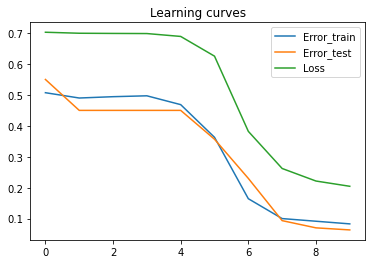

In [119]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(range(num_iter), errors_train)
plt.plot(range(num_iter), errors_test)
plt.plot(range(num_iter), losses)
plt.title("Learning curves")
plt.legend(['Error_train', 'Error_test', 'Loss'])
plt.show()

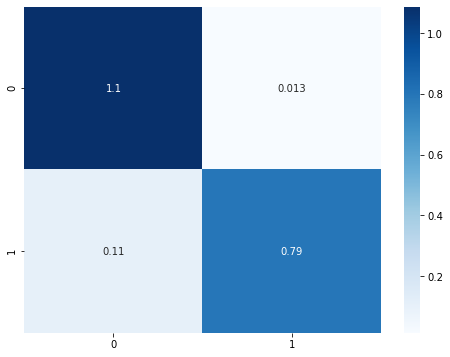

In [120]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for data in dataloader_test:
        
        inputs, labels = data[:,0:2], data[:,2]
        
        output = net(inputs.float()) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('0','1')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix)*2, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (8, 6))
sn.heatmap(df_cm, annot=True, cmap="Blues")
plt.show()

#### 2. 50 neuronów

In [115]:
net = torch.nn.Sequential(
    #torch.nn.Flatten(),
    torch.nn.Linear(2, 50), 
    torch.nn.ReLU(),
    torch.nn.Linear(50, 2)
)

def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.normal_(m.weight, std=0.01) 

net.apply(init_weights)


learning_rate = 0.05
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate) # Stochastic Gradient Descent


num_iter = 10
batch_size = 256
dataloader_train = torch.utils.data.DataLoader(np.array(df1), batch_size=1)
dataloader_test = torch.utils.data.DataLoader(np.array(df2), batch_size=1)

losses = []
errors_train = []
errors_test = []

for epoch in range(num_iter):
    losses_iter = []
    errors_train_iter = []
    errors_test_iter = []
    
    for data in dataloader_test:
        X, y = data[:,0:2],data[:,2].long()
        y_hat = net(X.float())
        errors_test_iter += [(y != y_hat.argmax(1)).float().mean().item()]

    for data in dataloader_train:
        X, y = data[:,0:2],data[:,2].long()
        y_hat = net(X.float())
        errors_train_iter += [(y != y_hat.argmax(1)).float().mean().item()]
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.mean().backward()
        losses_iter += [l.mean().item()]
        optimizer.step()
    
    errors_train += [np.mean(errors_train_iter)]
    errors_test += [np.mean(errors_test_iter)]
    losses += [np.mean(losses_iter)]

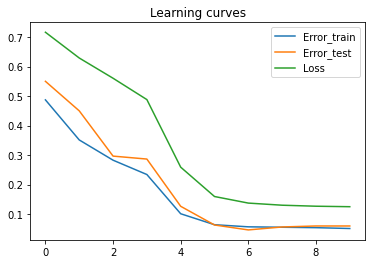

In [116]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(range(num_iter), errors_train)
plt.plot(range(num_iter), errors_test)
plt.plot(range(num_iter), losses)
plt.title("Learning curves")
plt.legend(['Error_train', 'Error_test', 'Loss'])
plt.show()

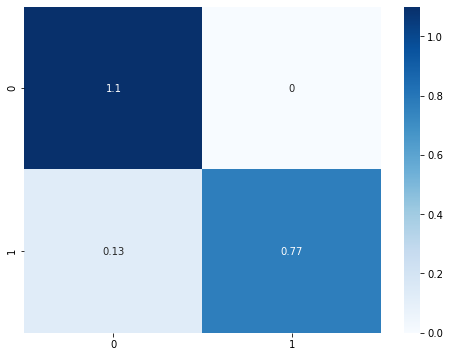

In [117]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for data in dataloader_test:
        
        inputs, labels = data[:,0:2], data[:,2]
        
        output = net(inputs.float()) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('0','1')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix)*2, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (8, 6))
sn.heatmap(df_cm, annot=True, cmap="Blues")
plt.show()

#### 3. 3 neurony

In [112]:
net = torch.nn.Sequential(
    #torch.nn.Flatten(),
    torch.nn.Linear(2, 3), 
    torch.nn.ReLU(),
    torch.nn.Linear(3, 2)
)

def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.normal_(m.weight, std=0.01) 

net.apply(init_weights)


learning_rate = 0.05
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate) # Stochastic Gradient Descent


num_iter = 10
batch_size = 256
dataloader_train = torch.utils.data.DataLoader(np.array(df1), batch_size=1)
dataloader_test = torch.utils.data.DataLoader(np.array(df2), batch_size=1)

losses = []
errors_train = []
errors_test = []

for epoch in range(num_iter):
    losses_iter = []
    errors_train_iter = []
    errors_test_iter = []
    
    for data in dataloader_test:
        X, y = data[:,0:2],data[:,2].long()
        y_hat = net(X.float())
        errors_test_iter += [(y != y_hat.argmax(1)).float().mean().item()]

    for data in dataloader_train:
        X, y = data[:,0:2],data[:,2].long()
        y_hat = net(X.float())
        errors_train_iter += [(y != y_hat.argmax(1)).float().mean().item()]
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.mean().backward()
        losses_iter += [l.mean().item()]
        optimizer.step()
    
    errors_train += [np.mean(errors_train_iter)]
    errors_test += [np.mean(errors_test_iter)]
    losses += [np.mean(losses_iter)]

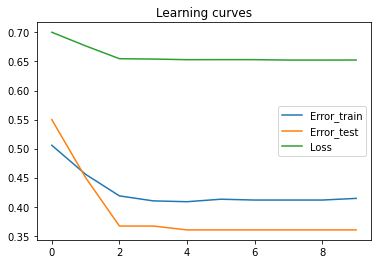

In [113]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(range(num_iter), errors_train)
plt.plot(range(num_iter), errors_test)
plt.plot(range(num_iter), losses)
plt.title("Learning curves")
plt.legend(['Error_train', 'Error_test', 'Loss'])
plt.show()

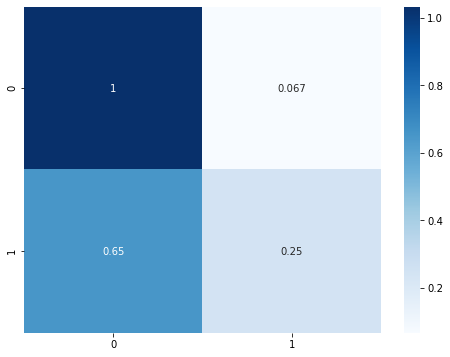

In [114]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for data in dataloader_test:
        
        inputs, labels = data[:,0:2], data[:,2]
        
        output = net(inputs.float()) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('0','1')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix)*2, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (8, 6))
sn.heatmap(df_cm, annot=True, cmap="Blues")
plt.show()

#### 4. 200 neuronów

In [106]:
net = torch.nn.Sequential(
    #torch.nn.Flatten(),
    torch.nn.Linear(2, 200), 
    torch.nn.ReLU(),
    torch.nn.Linear(200, 2)
)

def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.normal_(m.weight, std=0.01) 

net.apply(init_weights)


learning_rate = 0.05
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate) # Stochastic Gradient Descent


num_iter = 10
batch_size = 256
dataloader_train = torch.utils.data.DataLoader(np.array(df1), batch_size=1)
dataloader_test = torch.utils.data.DataLoader(np.array(df2), batch_size=1)

losses = []
errors_train = []
errors_test = []

for epoch in range(num_iter):
    losses_iter = []
    errors_train_iter = []
    errors_test_iter = []
    
    for data in dataloader_test:
        X, y = data[:,0:2],data[:,2].long()
        y_hat = net(X.float())
        errors_test_iter += [(y != y_hat.argmax(1)).float().mean().item()]

    for data in dataloader_train:
        X, y = data[:,0:2],data[:,2].long()
        y_hat = net(X.float())
        errors_train_iter += [(y != y_hat.argmax(1)).float().mean().item()]
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.mean().backward()
        losses_iter += [l.mean().item()]
        optimizer.step()
    
    errors_train += [np.mean(errors_train_iter)]
    errors_test += [np.mean(errors_test_iter)]
    losses += [np.mean(losses_iter)]

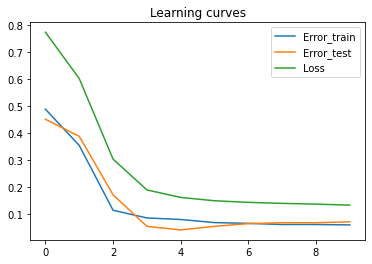

In [107]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(range(num_iter), errors_train)
plt.plot(range(num_iter), errors_test)
plt.plot(range(num_iter), losses)
plt.title("Learning curves")
plt.legend(['Error_train', 'Error_test', 'Loss'])
plt.show()

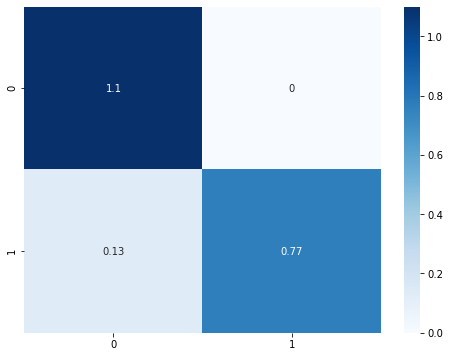

In [108]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for data in dataloader_test:
        
        inputs, labels = data[:,0:2], data[:,2]
        
        output = net(inputs.float()) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('0','1')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix)*2, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (8, 6))
sn.heatmap(df_cm, annot=True, cmap="Blues")
plt.show()

### Wnioski

Z analizy macierzy konfuzji oraz wykresu error i loss wynika, że zwiększanie liczby neuronów zwiększa skuteczność modelu do pewnego momentu. Różnica między 3 neuronami, a 10 jest znacząco. Natomiast 10, 50 oraz 200 neuronów w sieci nie robi większej różnicy dla modelu i nie jest on znacząco bardzije efektywny.

### Analiza zmiany parametru learning_rate

### 1. lr = 0.01

In [110]:
net = torch.nn.Sequential(
    #torch.nn.Flatten(),
    torch.nn.Linear(2, 10), 
    torch.nn.ReLU(),
    torch.nn.Linear(10, 2)
)

def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.normal_(m.weight, std=0.01) 

net.apply(init_weights)


learning_rate = 0.01
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate) # Stochastic Gradient Descent


num_iter = 10
batch_size = 256
dataloader_train = torch.utils.data.DataLoader(np.array(df1), batch_size=1)
dataloader_test = torch.utils.data.DataLoader(np.array(df2), batch_size=1)

losses = []
errors_train = []
errors_test = []

for epoch in range(num_iter):
    losses_iter = []
    errors_train_iter = []
    errors_test_iter = []
    
    for data in dataloader_test:
        X, y = data[:,0:2],data[:,2].long()
        y_hat = net(X.float())
        errors_test_iter += [(y != y_hat.argmax(1)).float().mean().item()]

    for data in dataloader_train:
        X, y = data[:,0:2],data[:,2].long()
        y_hat = net(X.float())
        errors_train_iter += [(y != y_hat.argmax(1)).float().mean().item()]
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.mean().backward()
        losses_iter += [l.mean().item()]
        optimizer.step()
    
    errors_train += [np.mean(errors_train_iter)]
    errors_test += [np.mean(errors_test_iter)]
    losses += [np.mean(losses_iter)]

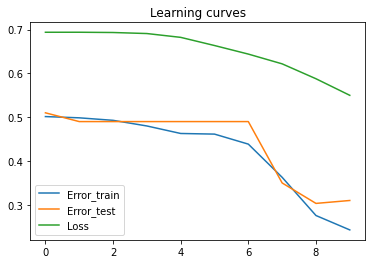

In [111]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(range(num_iter), errors_train)
plt.plot(range(num_iter), errors_test)
plt.plot(range(num_iter), losses)
plt.title("Learning curves")
plt.legend(['Error_train', 'Error_test', 'Loss'])
plt.show()

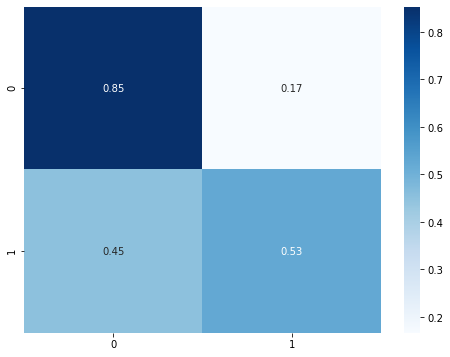

In [112]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for data in dataloader_test:
        
        inputs, labels = data[:,0:2], data[:,2]
        
        output = net(inputs.float()) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('0','1')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix)*2, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (8, 6))
sn.heatmap(df_cm, annot=True, cmap="Blues")
plt.show()

### 2. lr = 0.05

In [113]:
net = torch.nn.Sequential(
    #torch.nn.Flatten(),
    torch.nn.Linear(2, 10), 
    torch.nn.ReLU(),
    torch.nn.Linear(10, 2)
)

def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.normal_(m.weight, std=0.01) 

net.apply(init_weights)


learning_rate = 0.05
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate) # Stochastic Gradient Descent


num_iter = 10
batch_size = 256
dataloader_train = torch.utils.data.DataLoader(np.array(df1), batch_size=1)
dataloader_test = torch.utils.data.DataLoader(np.array(df2), batch_size=1)

losses = []
errors_train = []
errors_test = []

for epoch in range(num_iter):
    losses_iter = []
    errors_train_iter = []
    errors_test_iter = []
    
    for data in dataloader_test:
        X, y = data[:,0:2],data[:,2].long()
        y_hat = net(X.float())
        errors_test_iter += [(y != y_hat.argmax(1)).float().mean().item()]

    for data in dataloader_train:
        X, y = data[:,0:2],data[:,2].long()
        y_hat = net(X.float())
        errors_train_iter += [(y != y_hat.argmax(1)).float().mean().item()]
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.mean().backward()
        losses_iter += [l.mean().item()]
        optimizer.step()
    
    errors_train += [np.mean(errors_train_iter)]
    errors_test += [np.mean(errors_test_iter)]
    losses += [np.mean(losses_iter)]

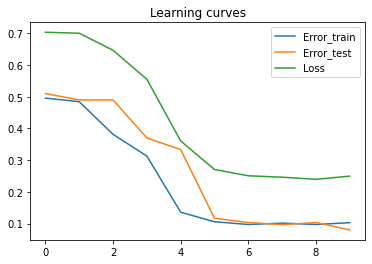

In [114]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(range(num_iter), errors_train)
plt.plot(range(num_iter), errors_test)
plt.plot(range(num_iter), losses)
plt.title("Learning curves")
plt.legend(['Error_train', 'Error_test', 'Loss'])
plt.show()

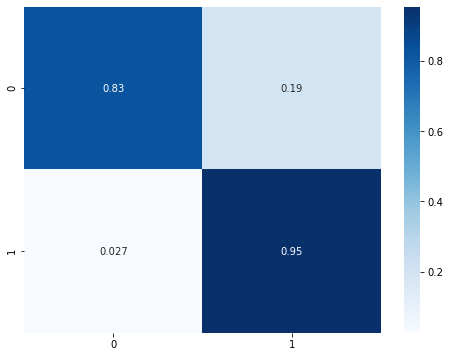

In [115]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for data in dataloader_test:
        
        inputs, labels = data[:,0:2], data[:,2]
        
        output = net(inputs.float()) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('0','1')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix)*2, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (8, 6))
sn.heatmap(df_cm, annot=True, cmap="Blues")
plt.show()

### 3. lr  = 0.2

In [116]:
net = torch.nn.Sequential(
    #torch.nn.Flatten(),
    torch.nn.Linear(2, 10), 
    torch.nn.ReLU(),
    torch.nn.Linear(10, 2)
)

def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.normal_(m.weight, std=0.01) 

net.apply(init_weights)


learning_rate = 0.2
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate) # Stochastic Gradient Descent


num_iter = 10
batch_size = 256
dataloader_train = torch.utils.data.DataLoader(np.array(df1), batch_size=1)
dataloader_test = torch.utils.data.DataLoader(np.array(df2), batch_size=1)

losses = []
errors_train = []
errors_test = []

for epoch in range(num_iter):
    losses_iter = []
    errors_train_iter = []
    errors_test_iter = []
    
    for data in dataloader_test:
        X, y = data[:,0:2],data[:,2].long()
        y_hat = net(X.float())
        errors_test_iter += [(y != y_hat.argmax(1)).float().mean().item()]

    for data in dataloader_train:
        X, y = data[:,0:2],data[:,2].long()
        y_hat = net(X.float())
        errors_train_iter += [(y != y_hat.argmax(1)).float().mean().item()]
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.mean().backward()
        losses_iter += [l.mean().item()]
        optimizer.step()
    
    errors_train += [np.mean(errors_train_iter)]
    errors_test += [np.mean(errors_test_iter)]
    losses += [np.mean(losses_iter)]

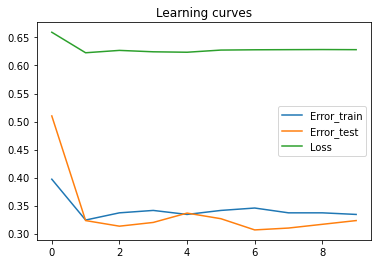

In [117]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(range(num_iter), errors_train)
plt.plot(range(num_iter), errors_test)
plt.plot(range(num_iter), losses)
plt.title("Learning curves")
plt.legend(['Error_train', 'Error_test', 'Loss'])
plt.show()

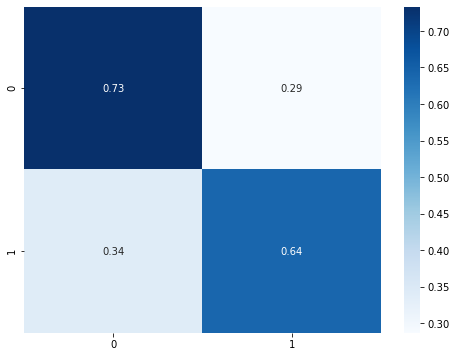

In [118]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for data in dataloader_test:
        
        inputs, labels = data[:,0:2], data[:,2]
        
        output = net(inputs.float()) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('0','1')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix)*2, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (8, 6))
sn.heatmap(df_cm, annot=True, cmap="Blues")
plt.show()

### 4. lr = 0.7

In [122]:
net = torch.nn.Sequential(
    #torch.nn.Flatten(),
    torch.nn.Linear(2, 10), 
    torch.nn.ReLU(),
    torch.nn.Linear(10, 2)
)

def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.normal_(m.weight, std=0.01) 

net.apply(init_weights)


learning_rate = 0.7
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate) # Stochastic Gradient Descent


num_iter = 10
batch_size = 256
dataloader_train = torch.utils.data.DataLoader(np.array(df1), batch_size=1)
dataloader_test = torch.utils.data.DataLoader(np.array(df2), batch_size=1)

losses = []
errors_train = []
errors_test = []

for epoch in range(num_iter):
    losses_iter = []
    errors_train_iter = []
    errors_test_iter = []
    
    for data in dataloader_test:
        X, y = data[:,0:2],data[:,2].long()
        y_hat = net(X.float())
        errors_test_iter += [(y != y_hat.argmax(1)).float().mean().item()]

    for data in dataloader_train:
        X, y = data[:,0:2],data[:,2].long()
        y_hat = net(X.float())
        errors_train_iter += [(y != y_hat.argmax(1)).float().mean().item()]
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.mean().backward()
        losses_iter += [l.mean().item()]
        optimizer.step()
    
    errors_train += [np.mean(errors_train_iter)]
    errors_test += [np.mean(errors_test_iter)]
    losses += [np.mean(losses_iter)]

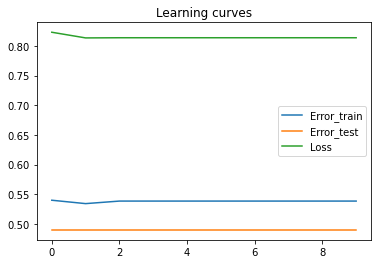

In [123]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(range(num_iter), errors_train)
plt.plot(range(num_iter), errors_test)
plt.plot(range(num_iter), losses)
plt.title("Learning curves")
plt.legend(['Error_train', 'Error_test', 'Loss'])
plt.show()

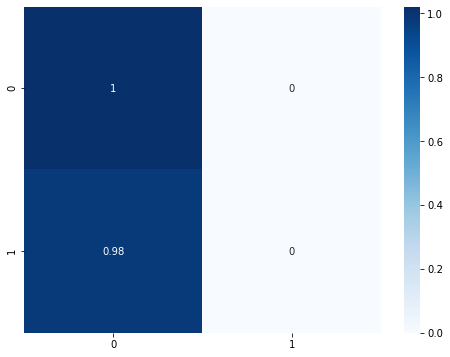

In [124]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for data in dataloader_test:
        
        inputs, labels = data[:,0:2], data[:,2]
        
        output = net(inputs.float()) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('0','1')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix)*2, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (8, 6))
sn.heatmap(df_cm, annot=True, cmap="Blues")
plt.show()

### Wnioski

Przy doborze parametru learning rate nie ma zasady, która mówiłaby, że im większa wartość parametru, tym bardziej efektywny model. O ile początkowy wzrost parametru learning rate zwiększa dokładność modelu, o tyle przy wartościach 0,2 oraz 0,7 model nie sprawdza się dobrze, a wręcz w ogóle nie pozwala przewidywać wartości.

## Model dla ramki danych iris

Model został stworzony za pomocą 2 ukrytych warstw, z których każda ma po 16 neuronów.

In [30]:
iris = datasets.load_iris()
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


In [31]:
dataloader_train = torch.utils.data.DataLoader(np.array(df), batch_size=1)
dataiter = iter(dataloader_train)
data = dataiter.next()

X, y = data[:,0:4],data[:,4]
X,y



(tensor([[5.1000, 3.5000, 1.4000, 0.2000]], dtype=torch.float64),
 tensor([0.], dtype=torch.float64))

In [32]:
# Podział na zbiór treningowy i testowy
df1, df2 = train_test_split(
    df[df.columns.values[:]],
    test_size=0.3, random_state=42)

In [33]:
net = torch.nn.Sequential(
    #torch.nn.Flatten(),
    torch.nn.Linear(4, 16), 
    torch.nn.ReLU(),
    torch.nn.Linear(16, 16), 
    torch.nn.ReLU(),
    torch.nn.Linear(16, 3)
)

def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.normal_(m.weight, std=0.01) 

net.apply(init_weights)

Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=3, bias=True)
)

In [34]:
learning_rate = 0.05
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate) # Stochastic Gradient Descent

In [35]:
num_iter = 40
batch_size = 256
dataloader_train = torch.utils.data.DataLoader(np.array(df1), batch_size=1)
dataloader_test = torch.utils.data.DataLoader(np.array(df2), batch_size=1)

losses = []
errors_train = []
errors_test = []

# import tqdm # pip install tqdm
# for epoch in tqdm.tqdm(range(num_iter)):
for epoch in range(num_iter):
    losses_iter = []
    errors_train_iter = []
    errors_test_iter = []
    
    for data in dataloader_test:
        X, y = data[:,0:4],data[:,4].long()
        y_hat = net(X.float())
        errors_test_iter += [(y != y_hat.argmax(1)).float().mean().item()]

    for data in dataloader_train:
        X, y = data[:,0:4],data[:,4].long()
        y_hat = net(X.float())
        errors_train_iter += [(y != y_hat.argmax(1)).float().mean().item()]
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.mean().backward()
        losses_iter += [l.mean().item()]
        optimizer.step()
    
    errors_train += [np.mean(errors_train_iter)]
    errors_test += [np.mean(errors_test_iter)]
    losses += [np.mean(losses_iter)]

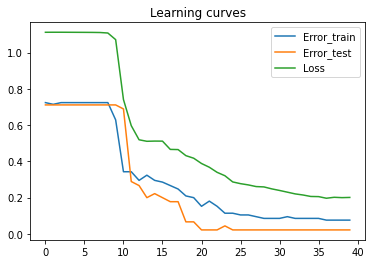

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(range(num_iter), errors_train)
plt.plot(range(num_iter), errors_test)
plt.plot(range(num_iter), losses)
plt.title("Learning curves")
plt.legend(['Error_train', 'Error_test', 'Loss'])
plt.show()

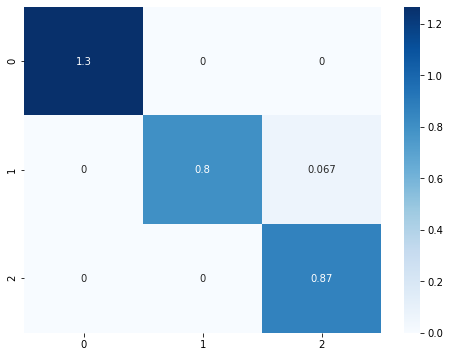

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for data in dataloader_test:
        
        inputs, labels = data[:,0:4], data[:,4]
        
        output = net(inputs.float()) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('0','1','2')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix)*3, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (8, 6))
sn.heatmap(df_cm, annot=True, cmap="Blues")
plt.show()

## Analiza Zbioru MNIST

Stworzymy i przeanalizujemy model dla zbioru danych MNIST, w którym znajdują został stworzony dla sieci neuronów z 3 ukrytymi warstwami, z których każda zawiera po 16 neuronów

In [40]:
mnist_train = torchvision.datasets.FashionMNIST(
    root="/data", train=True, transform=torchvision.transforms.ToTensor(), download=True
)
mnist_test = torchvision.datasets.FashionMNIST(
    root="/data", train=False, transform=torchvision.transforms.ToTensor(), download=True
)

In [41]:
mnist_train

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [31]:
net = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 16), # 28^2
    torch.nn.ReLU(),
    torch.nn.Linear(16, 16), # 28^2
    torch.nn.ReLU(),
    torch.nn.Linear(16, 16), # 28^2
    torch.nn.ReLU(),
    torch.nn.Linear(16, 10)
)

def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.normal_(m.weight, std=0.01) 

net.apply(init_weights)

learning_rate = 0.05
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate) # Stochastic Gradient Descent

num_iter = 64
batch_size = 256
dataloader_train = torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=2)
dataloader_test = torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=True, num_workers=2)

losses = []
errors_train = []
errors_test = []

# import tqdm # pip install tqdm
# for epoch in tqdm.tqdm(range(num_iter)):
for epoch in range(num_iter):
    losses_iter = []
    errors_train_iter = []
    errors_test_iter = []
    
    for X, y in dataloader_test:
        y_hat = net(X)
        errors_test_iter += [(y != y_hat.argmax(1)).float().mean().item()]

    for X, y in dataloader_train:
        y_hat = net(X)
        errors_train_iter += [(y != y_hat.argmax(1)).float().mean().item()]
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.mean().backward()
        losses_iter += [l.mean().item()]
        optimizer.step()
    
    errors_train += [np.mean(errors_train_iter)]
    errors_test += [np.mean(errors_test_iter)]
    losses += [np.mean(losses_iter)]

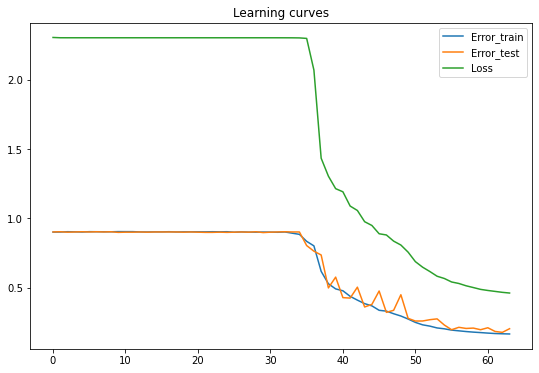

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 6))
plt.plot(range(num_iter), errors_train)
plt.plot(range(num_iter), errors_test)
plt.plot(range(num_iter), losses)
plt.title("Learning curves")
plt.legend(['Error_train', 'Error_test', 'Loss'])
plt.show()

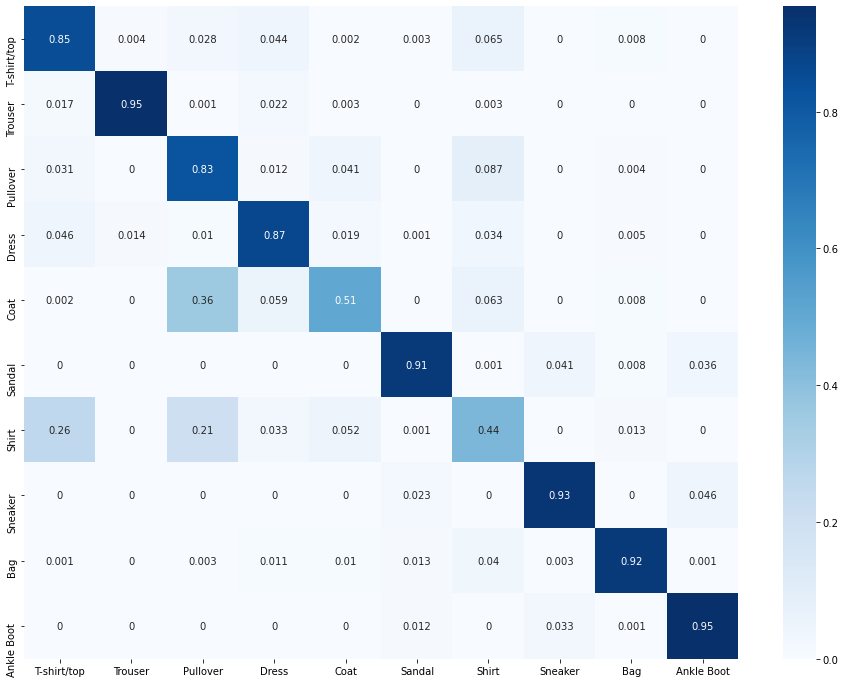

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in dataloader_test:
        output = net(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (16, 12))
sn.heatmap(df_cm, annot=True, cmap="Blues")
plt.show()

## Porównanie liczby warstw neuronów na zbiorze MNIST

Powyżej sprawdziliśmy przypadek dla 3 ukrytych warstw, sprawdzimy jak się przedstawia powyższy model, gdy zamiast 3 ukrytych warstw będą 2 lub tylko jedna.

### 2 warstwy

In [52]:
net = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 16), # 28^2
    torch.nn.ReLU(),
    torch.nn.Linear(16, 16), # 28^2
    torch.nn.ReLU(),
    torch.nn.Linear(16, 10)
)

def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.normal_(m.weight, std=0.01) 

net.apply(init_weights)

learning_rate = 0.05
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate) # Stochastic Gradient Descent

num_iter = 16
batch_size = 256
dataloader_train = torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=2)
dataloader_test = torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=True, num_workers=2)

losses = []
errors_train = []
errors_test = []

# import tqdm # pip install tqdm
# for epoch in tqdm.tqdm(range(num_iter)):
for epoch in range(num_iter):
    losses_iter = []
    errors_train_iter = []
    errors_test_iter = []
    
    for X, y in dataloader_test:
        y_hat = net(X)
        errors_test_iter += [(y != y_hat.argmax(1)).float().mean().item()]

    for X, y in dataloader_train:
        y_hat = net(X)
        errors_train_iter += [(y != y_hat.argmax(1)).float().mean().item()]
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.mean().backward()
        losses_iter += [l.mean().item()]
        optimizer.step()
    
    errors_train += [np.mean(errors_train_iter)]
    errors_test += [np.mean(errors_test_iter)]
    losses += [np.mean(losses_iter)]

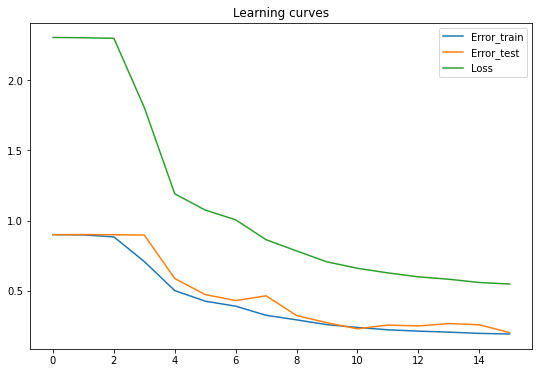

In [53]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 6))
plt.plot(range(num_iter), errors_train)
plt.plot(range(num_iter), errors_test)
plt.plot(range(num_iter), losses)
plt.title("Learning curves")
plt.legend(['Error_train', 'Error_test', 'Loss'])
plt.show()

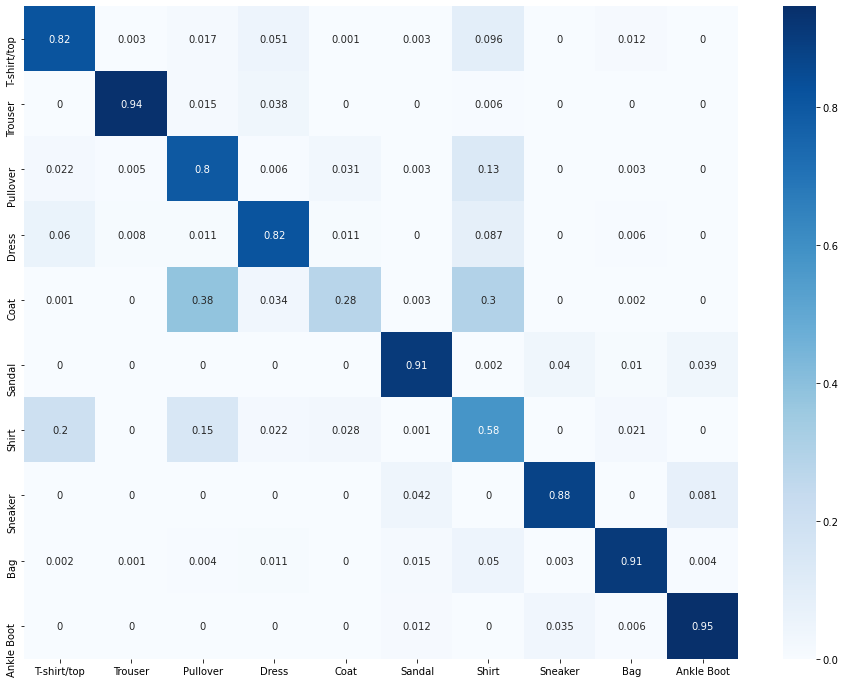

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in dataloader_test:
        output = net(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (16, 12))
sn.heatmap(df_cm, annot=True, cmap="Blues")
plt.show()

### 1 warstwa

In [46]:
net = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 16), # 28^2
    torch.nn.ReLU(),
    torch.nn.Linear(16, 10)
)

def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.normal_(m.weight, std=0.01) 

net.apply(init_weights)

learning_rate = 0.05
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate) # Stochastic Gradient Descent

num_iter = 16
batch_size = 256
dataloader_train = torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=2)
dataloader_test = torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=True, num_workers=2)

losses = []
errors_train = []
errors_test = []

# import tqdm # pip install tqdm
# for epoch in tqdm.tqdm(range(num_iter)):
for epoch in range(num_iter):
    losses_iter = []
    errors_train_iter = []
    errors_test_iter = []
    
    for X, y in dataloader_test:
        y_hat = net(X)
        errors_test_iter += [(y != y_hat.argmax(1)).float().mean().item()]

    for X, y in dataloader_train:
        y_hat = net(X)
        errors_train_iter += [(y != y_hat.argmax(1)).float().mean().item()]
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.mean().backward()
        losses_iter += [l.mean().item()]
        optimizer.step()
    
    errors_train += [np.mean(errors_train_iter)]
    errors_test += [np.mean(errors_test_iter)]
    losses += [np.mean(losses_iter)]

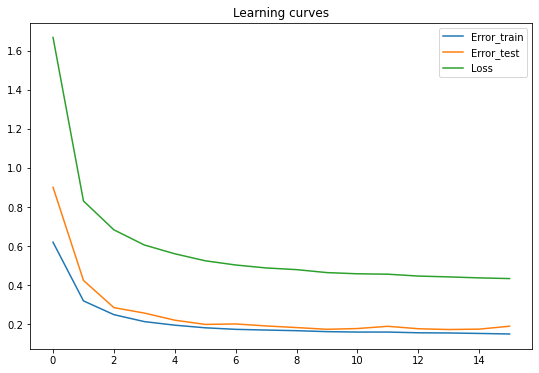

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 6))
plt.plot(range(num_iter), errors_train)
plt.plot(range(num_iter), errors_test)
plt.plot(range(num_iter), losses)
plt.title("Learning curves")
plt.legend(['Error_train', 'Error_test', 'Loss'])
plt.show()

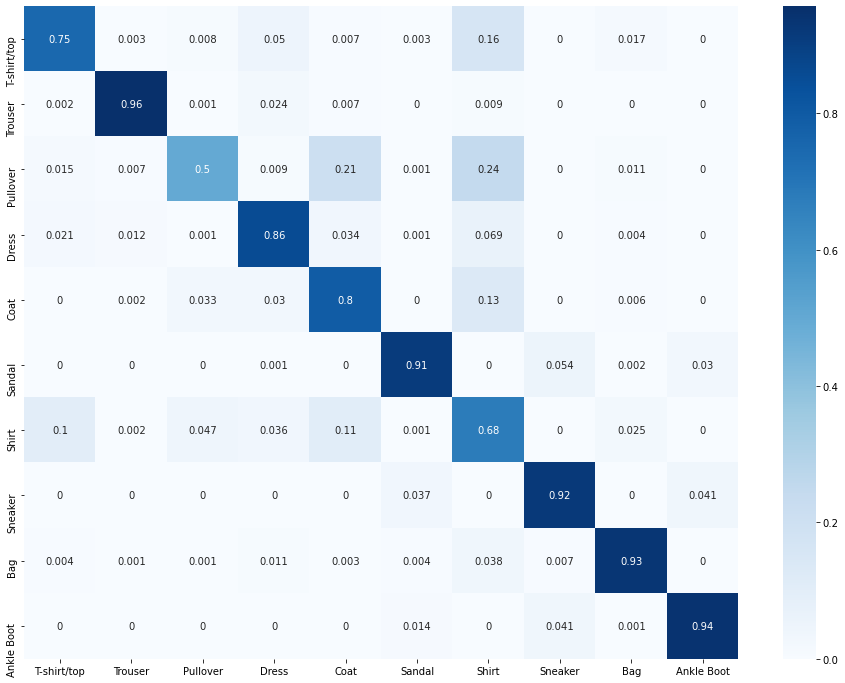

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in dataloader_test:
        output = net(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (16, 12))
sn.heatmap(df_cm, annot=True, cmap="Blues")
plt.show()

### Wnioski

1 warstwa neuronów sprawdziła się znaczne lepiej niż 2 ukryte warstwy sieci neuronowych. Widać to na przykładzie kolumny Coat dla której 2 warstwy sieci neuronowych dobrze klasyfikują zdjęcia w 28% natomiast 1 warstwa już w 80%. Tylko jedna warstwa neuronów lepiej przewiduje wynik niż 3 ukryte warstwy, co jest dosyć zaskakujące.

## Analiza zjawiska przeuczenia

In [55]:
iris = datasets.load_iris()
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


### 16 iteracji

In [80]:
dataloader_train = torch.utils.data.DataLoader(np.array(df), batch_size=1)

df1, df2 = train_test_split(
    df[df.columns.values[:]],
    test_size=0.3, random_state=42)

net = torch.nn.Sequential(
    #torch.nn.Flatten(),
    torch.nn.Linear(4, 16), 
    torch.nn.ReLU(),
    torch.nn.Linear(16, 16), 
    torch.nn.ReLU(),
    torch.nn.Linear(16, 3)
)

def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.normal_(m.weight, std=0.01) 

net.apply(init_weights)


learning_rate = 0.05
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate) # Stochastic Gradient Descent


num_iter = 16
batch_size = 256
dataloader_train = torch.utils.data.DataLoader(np.array(df1), batch_size=1)
dataloader_test = torch.utils.data.DataLoader(np.array(df2), batch_size=1)

losses = []
errors_train = []
errors_test = []

# import tqdm # pip install tqdm
# for epoch in tqdm.tqdm(range(num_iter)):
for epoch in range(num_iter):
    losses_iter = []
    errors_train_iter = []
    errors_test_iter = []
    
    for data in dataloader_test:
        X, y = data[:,0:4],data[:,4].long()
        y_hat = net(X.float())
        errors_test_iter += [(y != y_hat.argmax(1)).float().mean().item()]

    for data in dataloader_train:
        X, y = data[:,0:4],data[:,4].long()
        y_hat = net(X.float())
        errors_train_iter += [(y != y_hat.argmax(1)).float().mean().item()]
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.mean().backward()
        losses_iter += [l.mean().item()]
        optimizer.step()
    
    errors_train += [np.mean(errors_train_iter)]
    errors_test += [np.mean(errors_test_iter)]
    losses += [np.mean(losses_iter)]

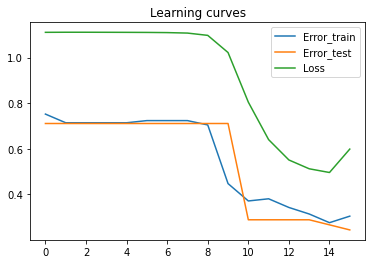

In [81]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(range(num_iter), errors_train)
plt.plot(range(num_iter), errors_test)
plt.plot(range(num_iter), losses)
plt.title("Learning curves")
plt.legend(['Error_train', 'Error_test', 'Loss'])
plt.show()

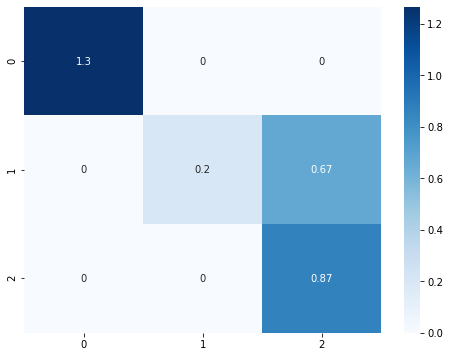

In [82]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for data in dataloader_test:
        
        inputs, labels = data[:,0:4], data[:,4]
        
        output = net(inputs.float()) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('0','1','2')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix)*3, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (8, 6))
sn.heatmap(df_cm, annot=True, cmap="Blues")
plt.show()

### 64 iteracje

In [83]:
dataloader_train = torch.utils.data.DataLoader(np.array(df), batch_size=1)

df1, df2 = train_test_split(
    df[df.columns.values[:]],
    test_size=0.3, random_state=42)

net = torch.nn.Sequential(
    #torch.nn.Flatten(),
    torch.nn.Linear(4, 16), 
    torch.nn.ReLU(),
    torch.nn.Linear(16, 16), 
    torch.nn.ReLU(),
    torch.nn.Linear(16, 3)
)

def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.normal_(m.weight, std=0.01) 

net.apply(init_weights)


learning_rate = 0.05
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate) # Stochastic Gradient Descent


num_iter = 64
batch_size = 256
dataloader_train = torch.utils.data.DataLoader(np.array(df1), batch_size=1)
dataloader_test = torch.utils.data.DataLoader(np.array(df2), batch_size=1)

losses = []
errors_train = []
errors_test = []

# import tqdm # pip install tqdm
# for epoch in tqdm.tqdm(range(num_iter)):
for epoch in range(num_iter):
    losses_iter = []
    errors_train_iter = []
    errors_test_iter = []
    
    for data in dataloader_test:
        X, y = data[:,0:4],data[:,4].long()
        y_hat = net(X.float())
        errors_test_iter += [(y != y_hat.argmax(1)).float().mean().item()]

    for data in dataloader_train:
        X, y = data[:,0:4],data[:,4].long()
        y_hat = net(X.float())
        errors_train_iter += [(y != y_hat.argmax(1)).float().mean().item()]
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.mean().backward()
        losses_iter += [l.mean().item()]
        optimizer.step()
    
    errors_train += [np.mean(errors_train_iter)]
    errors_test += [np.mean(errors_test_iter)]
    losses += [np.mean(losses_iter)]

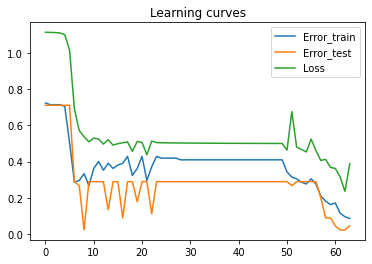

In [84]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(range(num_iter), errors_train)
plt.plot(range(num_iter), errors_test)
plt.plot(range(num_iter), losses)
plt.title("Learning curves")
plt.legend(['Error_train', 'Error_test', 'Loss'])
plt.show()

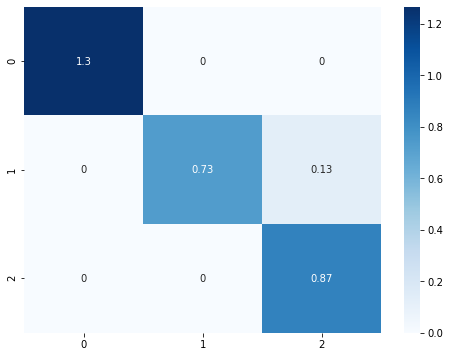

In [85]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for data in dataloader_test:
        
        inputs, labels = data[:,0:4], data[:,4]
        
        output = net(inputs.float()) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('0','1','2')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix)*3, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (8, 6))
sn.heatmap(df_cm, annot=True, cmap="Blues")
plt.show()

### 1024 iteracje

In [77]:
dataloader_train = torch.utils.data.DataLoader(np.array(df), batch_size=1)

df1, df2 = train_test_split(
    df[df.columns.values[:]],
    test_size=0.3, random_state=42)

net = torch.nn.Sequential(
    #torch.nn.Flatten(),
    torch.nn.Linear(4, 16), 
    torch.nn.ReLU(),
    torch.nn.Linear(16, 16), 
    torch.nn.ReLU(),
    torch.nn.Linear(16, 3)
)

def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.normal_(m.weight, std=0.01) 

net.apply(init_weights)


learning_rate = 0.05
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate) # Stochastic Gradient Descent


num_iter = 1024
batch_size = 256
dataloader_train = torch.utils.data.DataLoader(np.array(df1), batch_size=1)
dataloader_test = torch.utils.data.DataLoader(np.array(df2), batch_size=1)

losses = []
errors_train = []
errors_test = []

# import tqdm # pip install tqdm
# for epoch in tqdm.tqdm(range(num_iter)):
for epoch in range(num_iter):
    losses_iter = []
    errors_train_iter = []
    errors_test_iter = []
    
    for data in dataloader_test:
        X, y = data[:,0:4],data[:,4].long()
        y_hat = net(X.float())
        errors_test_iter += [(y != y_hat.argmax(1)).float().mean().item()]

    for data in dataloader_train:
        X, y = data[:,0:4],data[:,4].long()
        y_hat = net(X.float())
        errors_train_iter += [(y != y_hat.argmax(1)).float().mean().item()]
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.mean().backward()
        losses_iter += [l.mean().item()]
        optimizer.step()
    
    errors_train += [np.mean(errors_train_iter)]
    errors_test += [np.mean(errors_test_iter)]
    losses += [np.mean(losses_iter)]

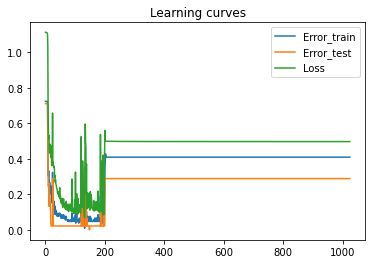

In [78]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(range(num_iter), errors_train)
plt.plot(range(num_iter), errors_test)
plt.plot(range(num_iter), losses)
plt.title("Learning curves")
plt.legend(['Error_train', 'Error_test', 'Loss'])
plt.show()

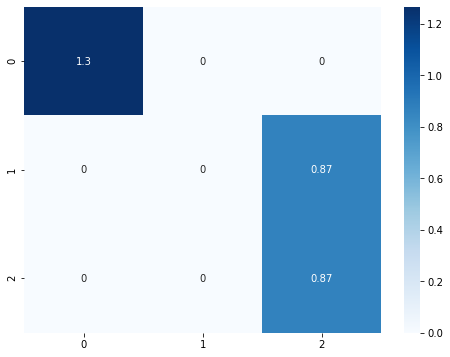

In [79]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for data in dataloader_test:
        
        inputs, labels = data[:,0:4], data[:,4]
        
        output = net(inputs.float()) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('0','1','2')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix)*3, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (8, 6))
sn.heatmap(df_cm, annot=True, cmap="Blues")
plt.show()

### Wnioski

Do pewnego momentu zwiększanie liczby iteracji poprawiało skuteczność modelu. Natomiast dla przypadku 1024 iteracji model przestaje dobrze przewidywać i kompletnie się wywala.